# Statistical analysis of living habits of individual persons and households

#### Authors
- Jasmine Lundgren
- Ha Do
- Roosa Muranen


## Load data

We'll start the data analysis process by importing necessary libraries and loading the data. We will only import the columns which are examined in the analysis and we also will replace question mark values by NaN values.

In [ ]:
# Import libaries are needed for data processing
import pandas as pd
import numpy as np
import scipy.stats as s
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats as ss
import statsmodels.stats.multitest as ssm


#Load and read dataset from a file called habits.data
file_path = 'habits.data'

data = pd.read_csv(file_path, sep=';', skiprows=1, usecols=[0, 1, 2, 3, 4, 5, 7, 8, 16, 18, 21, 22], names=['household ID', 'member ID', 'Day of week', 'Sex', 'Living environment', 'Age group',
                                                                                                                         'Cooking', 'Washing dishes', 'Listening to radio', 'Phonecall',
                                                                                                                         'Museum', 'Library'], na_values=['?'])

data.head()

,household ID,member ID,Day of week,Sex,Living environment,Age group,Cooking,Washing dishes,Listening to radio,Phonecall,Museum,Library
0,50007,2,2,2,3.0,6,0,20,0,0,2.0,1.0
1,50009,1,1,2,1.0,7,40,0,0,0,2.0,1.0
2,50015,1,1,1,3.0,8,10,0,10,0,2.0,1.0
3,50032,2,1,1,2.0,8,0,10,0,0,2.0,2.0
4,50033,1,1,2,1.0,8,02:10,00:20,00:00,00:00,2.0,2.0


## Data preparation and exploration

We classify data into categorical and numeric variables since they have different data types. Columns such as sex, living environment, age group, museum, and library are classified as categorical because they do not have continuous values like numerical columns. These variables represent different demographic information, such as gender, living environment, age group, and has a person visited a museum or a library. Meanwhile, numerical data includes how an individual has spent time on different activities such as cooking, washing dishes, listening to radio, and making phone calls.

In [ ]:
# Define numerical_columns
numerical_columns = ['Cooking', 'Washing dishes', 'Listening to radio', 'Phonecall']
# Define categorial columns
categorical_columns = ['Day of week', 'Sex', 'Living environment', 'Age group', 'Museum', 'Library']

As we start to inspect the data, we can see, that all of the household id values are unique. That leads us to a conclusion that there's only one person per household in our data.

In [ ]:
# There seems to be no duplicate household_ids so we assume there's only one person per household
print(len(data))
print(len(pd.unique(data['household ID'])))

393
393


When we check for missing values, we can see, that there's 44 rows containing NaN values. After calculating missing values for all variables, it seems that most of the missing values belong to the museum and library activities.

In [ ]:
# Check if any missing values
data.isna().any(axis=1).sum()

44

In [ ]:
# Check missing values by variable
data.isnull().sum()

,0
household ID,0
member ID,0
Day of week,0
Sex,0
Living environment,1
Age group,0
Cooking,5
Washing dishes,4
Listening to radio,4
Phonecall,7


We decided to drop the rows with null values since the number of rows with them isn't too high and most missing values are in the museum and library columns, which can only get yes or no values, so replacing a null value with the mean could sway the results.

In [ ]:
# Drop rows have NaN values
data.dropna(inplace=True)

data.head()

,household ID,member ID,Day of week,Sex,Living environment,Age group,Cooking,Washing dishes,Listening to radio,Phonecall,Museum,Library
0,50007,2,2,2,3.0,6,0,20,0,0,2.0,1.0
1,50009,1,1,2,1.0,7,40,0,0,0,2.0,1.0
2,50015,1,1,1,3.0,8,10,0,10,0,2.0,1.0
3,50032,2,1,1,2.0,8,0,10,0,0,2.0,2.0
4,50033,1,1,2,1.0,8,02:10,00:20,00:00,00:00,2.0,2.0


After dealing with the missing values, we observe the categorical variables for erronous data. By observing the printed values we can see that there's some erronous data with museum and library variables.

In [ ]:
# Check categorical variables for odd values before converting
print((data['Day of week'] < 1).value_counts())
print((data['Day of week'] > 2).value_counts())

print((data['Sex'] < 1).value_counts())
print((data['Sex'] > 2).value_counts())

print((data['Living environment'] < 1).value_counts())
print((data['Living environment'] > 3).value_counts())

print((data['Age group'] < 1).value_counts())
print((data['Age group'] > 9).value_counts())

print((data['Museum'] < 1).value_counts())
print((data['Museum'] > 2).value_counts())

print((data['Library']< 1).value_counts())
print((data['Library'] > 2).value_counts())

Day of week
False    349
Name: count, dtype: int64
Day of week
False    349
Name: count, dtype: int64
Sex
False    349
Name: count, dtype: int64
Sex
False    349
Name: count, dtype: int64
Living environment
False    349
Name: count, dtype: int64
Living environment
False    349
Name: count, dtype: int64
Age group
False    349
Name: count, dtype: int64
Age group
False    349
Name: count, dtype: int64
Museum
False    345
True       4
Name: count, dtype: int64
Museum
False    347
True       2
Name: count, dtype: int64
Library
False    343
True       6
Name: count, dtype: int64
Library
False    349
Name: count, dtype: int64


We decided to drop the erronous rows for the same reasons as with the whole dataset.

In [ ]:
# Some erronous data on visited_library and visited_museum columns
# Drop the rows
index = data[(data['Museum'] < 1)].index
data.drop(index, inplace=True)

index = data[(data['Museum'] > 2)].index
data.drop(index, inplace=True)

index = data[(data['Library'] < 1)].index
data.drop(index, inplace=True)

print((data['Museum'] < 1).value_counts())
print((data['Museum'] > 2).value_counts())
print((data['Library'] < 1).value_counts())

Museum
False    343
Name: count, dtype: int64
Museum
False    343
Name: count, dtype: int64
Library
False    343
Name: count, dtype: int64


When we have all set with the categorical variables in the data, we'll rename the values to be more descriptive and change the variables' datatype to category.

In [ ]:
# Map encoded values to their corresponding labels
data['Day of week'] = data['Day of week'].map({1: 'working day', 2: 'weekend'})
data['Sex'] = data['Sex'].map({1: 'Male', 2: 'Female'})
data['Living environment'] = data['Living environment'].map({1: 'City', 2: 'Municipality', 3: 'Rural'})
data['Age group'] = data['Age group'].map({
    1: '10-14 years old', 2: '15-19 years old', 3: '20-24 years old',
    4: '25-34 years old', 5: '35-44 years old', 6: '45-54 years old',
    7: '55-64 years old', 8: '65-74 years old', 9: '75+ years old'
})
data['Museum'] = data['Museum'].map({1: 'Yes', 2: 'No'})
data['Library'] = data['Library'].map({1: 'Yes', 2: 'No'})
# Convert all categorial columns to category datatype
for col in categorical_columns:
    data[col] = data[col].astype('category')
data.head()

,household ID,member ID,Day of week,Sex,Living environment,Age group,Cooking,Washing dishes,Listening to radio,Phonecall,Museum,Library
0,50007,2,weekend,Female,Rural,45-54 years old,0,20,0,0,No,Yes
1,50009,1,working day,Female,City,55-64 years old,40,0,0,0,No,Yes
2,50015,1,working day,Male,Rural,65-74 years old,10,0,10,0,No,Yes
3,50032,2,working day,Male,Municipality,65-74 years old,0,10,0,0,No,No
4,50033,1,working day,Female,City,65-74 years old,02:10,00:20,00:00,00:00,No,No


While glancing the first few rows of the data, we notice that there are some
values in the activity variables that are in "hh:mm" format instead of the expected minute format. We have to convert those values to minute format, so we created a function for that and applied it to the activity variables. In addition, we changed the variables' datatype to int64.

In [ ]:
# Convert time like 00:20 in numerical_columns into numerical format
# Regex for hh:mm
pattern = re.compile('^([0-1]?[0-9]|2[0-3]):[0-5][0-9]$')

In [ ]:
# Create a function to convert
def convert(value):
    if isinstance(value, str) and pattern.match(value):
        hours, minutes = map(int, value.split(':'))
        return hours * 60 + minutes
    return int(value)
# Apply convestion into numerical_columns
for col in numerical_columns:
    data[col] = data[col].apply(convert).astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343 entries, 0 to 391
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   household ID        343 non-null    int64   
 1   member ID           343 non-null    int64   
 2   Day of week         343 non-null    category
 3   Sex                 343 non-null    category
 4   Living environment  343 non-null    category
 5   Age group           343 non-null    category
 6   Cooking             343 non-null    int64   
 7   Washing dishes      343 non-null    int64   
 8   Listening to radio  343 non-null    int64   
 9   Phonecall           343 non-null    int64   
 10  Museum              343 non-null    category
 11  Library             343 non-null    category
dtypes: category(6), int64(6)
memory usage: 21.7 KB


After the numerical variables had been converted to the suitable format and datatype, we inspect the variables for erronous values. From the output we could see that there weren't any radical values.

In [ ]:
# Check numerical variables for odd values
print((data['Cooking'] < 0).value_counts())
print((data['Washing dishes'] < 0).value_counts())
print((data['Listening to radio'] < 0).value_counts())
print((data['Phonecall'] < 0).value_counts())

print((data['Cooking'] > 1000).value_counts())
print((data['Washing dishes'] > 1000).value_counts())
print((data['Listening to radio'] > 1000).value_counts())
print((data['Phonecall'] > 1000).value_counts())

Cooking
False    343
Name: count, dtype: int64
Washing dishes
False    343
Name: count, dtype: int64
Listening to radio
False    343
Name: count, dtype: int64
Phonecall
False    343
Name: count, dtype: int64
Cooking
False    343
Name: count, dtype: int64
Washing dishes
False    343
Name: count, dtype: int64
Listening to radio
False    343
Name: count, dtype: int64
Phonecall
False    343
Name: count, dtype: int64


We also want to observe the maximum and minimum values for the activity variables.\
The highest value for time spent on an activity is listening to radio. While the number seems to be quite high, by converting it to hours (~8,3 h) we can see that it's a plausible value since e.g. a person could listen to radio while working or use a radio as a background noise. The second highest value is for cooking which also seems extraordinary (6 h) but can be considered as a possibly correct value. \
The lowest value for all activities is 0. It's a plausible value for each activity while it may seem unlikely.

In [ ]:
# What are maximum values for each activity
data[numerical_columns].max()

,0
Cooking,360
Washing dishes,110
Listening to radio,500
Phonecall,110


In [ ]:
# What are minimum values for each activity
data[numerical_columns].min()

,0
Cooking,0
Washing dishes,0
Listening to radio,0
Phonecall,0


Next for getting a basic overview of the data, we calculate some sums based on the individuals' demographic features.

While there weren't any drastic difference in the amount of individuals for each sex, we could see that there is slightly more females than males in the dataset.

In [ ]:
# How many representatives for each sex
print('Male:')
print(data[data.Sex == 'Male'].shape[0])
print('Female:')
print(data[data.Sex == 'Female'].shape[0])

Male:
153
Female:
190


<Axes: xlabel='Sex'>

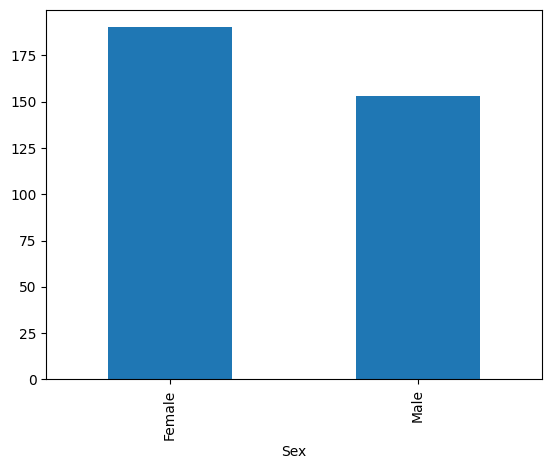

In [ ]:
data['Sex'].value_counts().plot(kind='bar')

When it comes to the individuals' living environment, we could witness that most of the individuals live in the city and the least in the municipality.

In [ ]:
# How many representatives for each living environment
print('City:')
print(data[data['Living environment'] == 'City'].shape[0])
print('Municipality:')
print(data[data['Living environment'] == 'Municipality'].shape[0])
print('Rural area:')
print(data[data['Living environment'] == 'Rural'].shape[0])

City:
212
Municipality:
55
Rural area:
76


<Axes: xlabel='Living environment'>

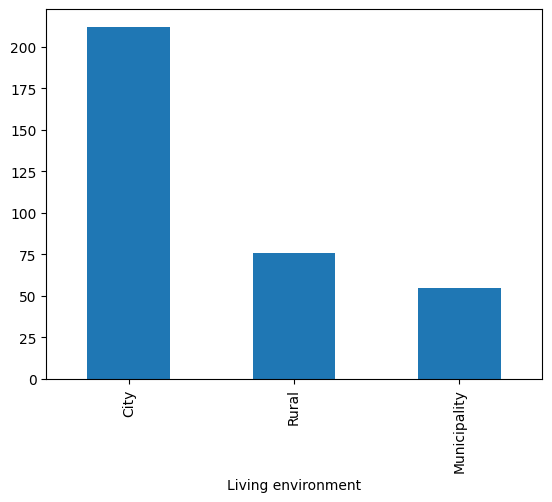

In [ ]:
data['Living environment'].value_counts().plot(kind='bar')

When observing the number of individuals in each age group, we can state that most of the individuals in the data are over 45 years old. There seems to be no representatives of the age groups between 10-19 year olds. The largest age groups in the data are between 45-64 year olds.

In [ ]:
# How many representatives for each age group
print('10-14 years old:')
print(data[data['Age group'] == '10-14 years old'].shape[0])
print('15-19 years old:')
print(data[data['Age group'] == '15-19 years old'].shape[0])
print('20-24 years old:')
print(data[data['Age group'] == '20-24 years old'].shape[0])
print('25-34 years old:')
print(data[data['Age group'] == '25-34 years old'].shape[0])
print('35-44 years old:')
print(data[data['Age group'] == '35-44 years old'].shape[0])
print('45-54 years old:')
print(data[data['Age group'] == '45-54 years old'].shape[0])
print('55-64 years old:')
print(data[data['Age group'] == '55-64 years old'].shape[0])
print('65-74 years old:')
print(data[data['Age group'] == '65-74 years old'].shape[0])
print('75+ years old:')
print(data[data['Age group'] == '75+ years old'].shape[0])

10-14 years old:
0
15-19 years old:
0
20-24 years old:
11
25-34 years old:
48
35-44 years old:
52
45-54 years old:
80
55-64 years old:
80
65-74 years old:
47
75+ years old:
25


<Axes: xlabel='Age group'>

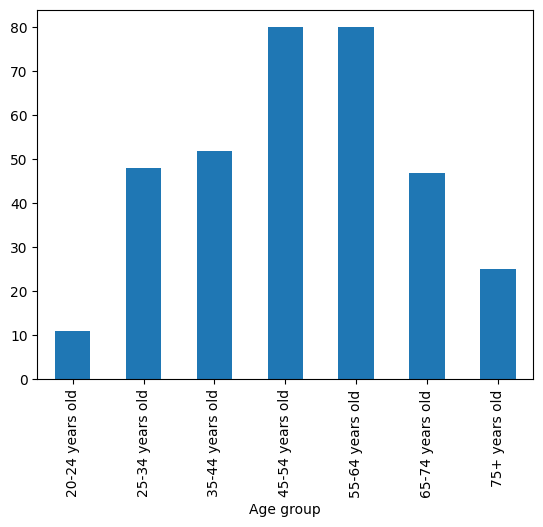

In [ ]:
data['Age group'].value_counts(sort=False).plot(kind='bar')

##1. Characterising individuals present in the data

One of the descriptive statistic methods we use is K-Prototypes clustering, aiming to group similar individuals into three clusters based on the individual's sex, age group, living environment, how they spent time on the different activities and have they visited library or museum in the past year.\
K-prototypes combine two clustering algorithms: K-means that groups data points together based on their similarity in distance to the centroid of their respective clusters and K-modes that calculates the number of mismatches between categorical values [4], [7].\
K-prototypes was thought to be the most suitable option to apply to our dataset, since it contains both categorical and numerical variables.

In [ ]:
# Define categorical columns for clustering
categorical_columns_clus = ['Sex', 'Living environment', 'Age group', 'Museum', 'Library']

# Combine all columns for clustering
all_columns = categorical_columns_clus + numerical_columns

# Define the indices of categorical columns in the DataFrame
categorical_indices = [all_columns.index(col) for col in categorical_columns_clus]

# Initialize K prototype model
kproto = KPrototypes(n_clusters=3, random_state=42)
clusters = kproto.fit_predict(data[all_columns], categorical=categorical_indices)

# Add cluster to data
data['Cluster'] = clusters
data.head()


,household ID,member ID,Day of week,Sex,Living environment,Age group,Cooking,Washing dishes,Listening to radio,Phonecall,Museum,Library,Cluster
0,50007,2,weekend,Female,Rural,45-54 years old,0,20,0,0,No,Yes,1
1,50009,1,working day,Female,City,55-64 years old,40,0,0,0,No,Yes,1
2,50015,1,working day,Male,Rural,65-74 years old,10,0,10,0,No,Yes,1
3,50032,2,working day,Male,Municipality,65-74 years old,0,10,0,0,No,No,1
4,50033,1,working day,Female,City,65-74 years old,130,20,0,0,No,No,2


In [ ]:
# Summarize demographic and activities in each cluster
cluster_summary = data.groupby('Cluster').agg({
    'Age group': lambda x: x.mode()[0],  # Most common age group in each cluster
    'Sex': lambda x: x.mode()[0],        # Most common sex in each cluster
    'Living environment': lambda x: x.mode()[0],  # Most common living environment
    'Cooking': 'mean',
    'Washing dishes': 'mean',
    'Listening to radio': 'mean',
    'Phonecall': 'mean',
    'Museum': lambda x: x.mode()[0], # Most common visit or not visit in each cluster
    'Library': lambda x: x.mode()[0] # Most common visit or not visit in each cluster
})

print("Cluster Summary:\n", cluster_summary)

Cluster Summary:
                Age group     Sex Living environment    Cooking  \
Cluster                                                          
0        55-64 years old    Male               City  41.666667   
1        55-64 years old    Male               City  15.506608   
2        65-74 years old  Female               City  80.909091   

         Washing dishes  Listening to radio  Phonecall Museum Library  
Cluster                                                                
0             10.000000          235.000000   0.000000     No      No  
1              5.286344            4.757709   4.185022     No     Yes  
2             28.000000            4.090909  11.363636     No     Yes  


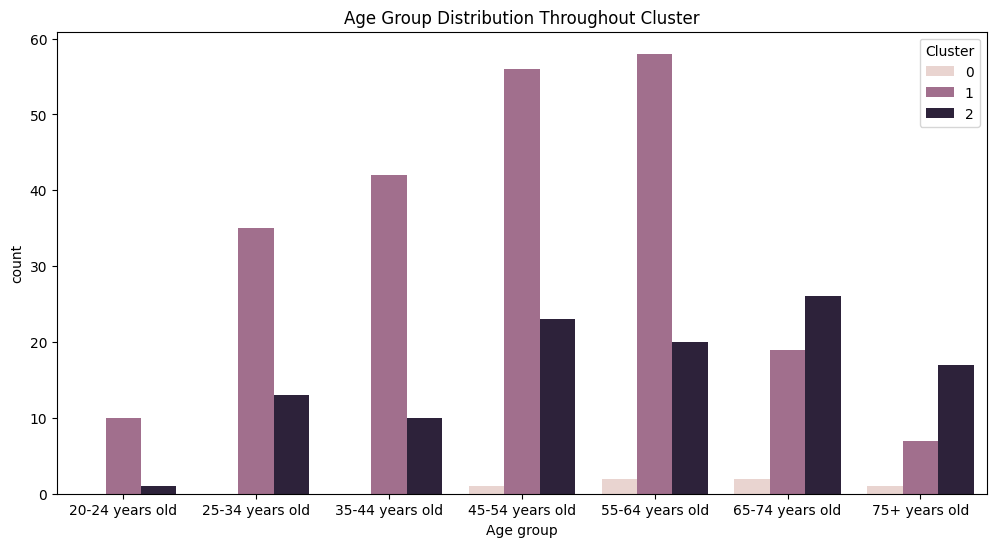

In [ ]:
# Visualize the distribution of Age groups within each cluster
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='Age group', hue='Cluster')
plt.title('Age Group Distribution Throughout Cluster')
plt.show()

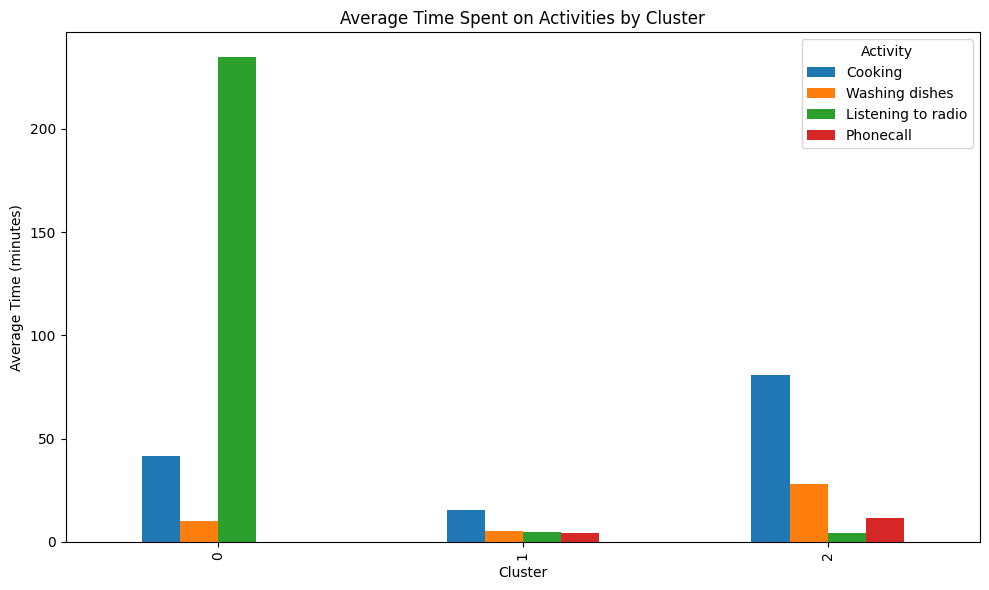

In [ ]:
# Calulate average time spent on activities for each cluster
activity_means = data.groupby('Cluster')[numerical_columns].mean().reset_index()
# Plot average time spent activity throughout each cluster
activity_means.set_index('Cluster').plot(kind='bar', figsize=(10, 6))
plt.title('Average Time Spent on Activities by Cluster')
plt.ylabel('Average Time (minutes)')
plt.xlabel('Cluster')
plt.legend(title='Activity', loc='upper right')
plt.tight_layout()
plt.show()

Based on the cluster summary, the clustering process describes three different groups (cluster 0, cluster 1, cluster 2). Each cluster represents individuals with specific characterics based on their demographics and time spent on different activities. The cluster summary interprets age group, sex, living environment, and time spent on various activities, such as cooking, washing dishes, listening to radio and phonecalls.

#### Cluster 0
- This cluster primarily includes people in the 55-64 years old age group, with mostly males living in the city
- Activities: On average, cooking and listening to radio take up the most time each day (41.6 and 235 minutes, respectively). The third most time is spent on washing dishes which was 10 minutes per day on average. Lastly, museum and libary are two activities which were not attractive to this group and they did not vist in the past 12 months.

#### Cluster 1
- This cluster primarily includes people in the 45-54 years old age group, with mostly males living in the city
- Activities: On average, cooking and washing dishes take up the most time each day (16.05 and 5.3 minutes, respectively). The next most time is spent on listenting to radio and phonecalls which accounts for about 4.6 and 4 minutes per day on average. Visiting libraries is a common interest among this group whereas visiting museums has not been in their interests in the past 12 months.

#### Cluster 2
- This cluster primarily includes people in the 45-54 years old age group, with mostly females living in the city
- Activities: On average, cooking and washing dishes take up the most time each day (80.3 and 29.3 minutes, respectively). The next most time is spent on listenting to radio and phonecalls which accounts for 3.3 and 12.08 minutes per day on average. Visiting libraries is a preferred activity for this group whereas visiting museums has not been in their interests in the past 12 months.

#### Summary
- Cluster 0 and 1 have gender and living area in common (male and city). Cluster 0 tends to spend more time on listening to radio and cooking whereas cluster 1 prefer visiting library and spend time on other categories than cluster 0. The cluster 2 has a similar age with cluster 1 and similar habits to visit library in the past 12 months, and this cluster spend the most their time on cooking and washing dishes as well as phone calls in comparison to the other 2 clusters. This is an indication that females in the sample group tended to spend more time on housework than other activities whereas males preferred enjoying other activities.


We liked to see, how many individuals was there in each cluster to verify our findings.

In [ ]:
# Checking how many people per cluster
print(data[data.Cluster == 0].shape[0])
print(data[data.Cluster == 1].shape[0])
print(data[data.Cluster == 2].shape[0])

6
227
110


As we can see, these clusters have large differences in their populations, which can affect the results and values the groups get. A single outlier in a small group can have a large impact on the results, as we see with the amount of time spent listening to radio by cluster 0, which only has 6 people in it.

We want to know more about the individuals in the data outside of clustering so we calculated and visualised how participants in different demographics spend their time to have a better overiview of the individuals' behavior.

Average Time Spent on Activities by day of week:
                Cooking  Washing dishes  Listening to radio  Phonecall
Day of week                                                          
weekend      33.595506        9.831461            9.213483   5.842697
working day  40.545455       15.696970            7.878788   7.030303


<ipython-input-27-c44c9dee0fab>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity_means = data.groupby('Day of week')[numerical_columns].mean()


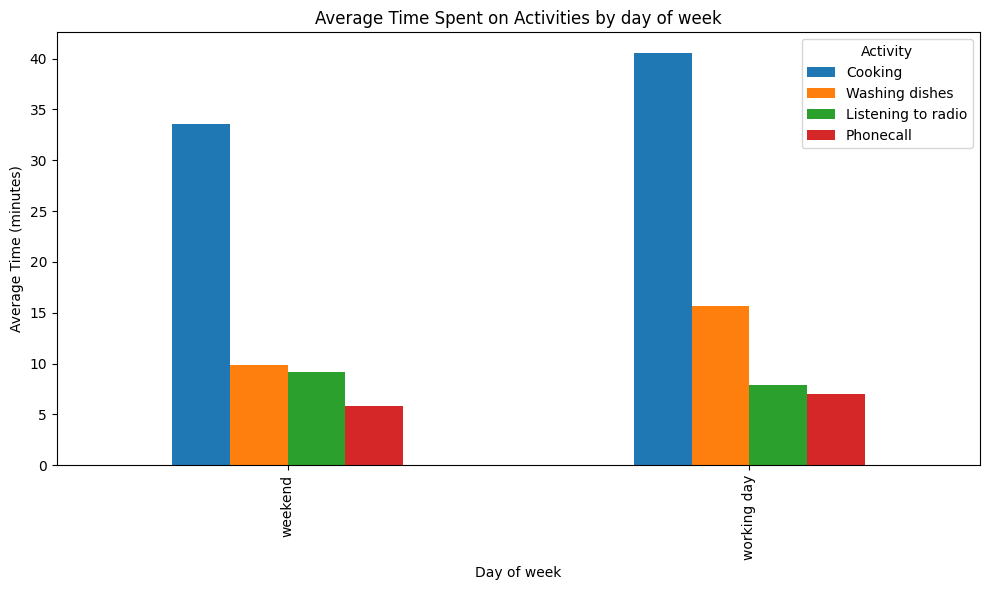

In [ ]:
# Calculate the average time spent on differences in activities based on day of week
activity_means = data.groupby('Day of week')[numerical_columns].mean()

# Display the average time for activities by day of week
print("Average Time Spent on Activities by day of week:\n", activity_means)

# Visualize the comparison using a bar plot
activity_means.plot(kind='bar', figsize=(10, 6))
plt.title('Average Time Spent on Activities by day of week')
plt.ylabel('Average Time (minutes)')
plt.xlabel('Day of week')
plt.legend(title='Activity', loc='upper right')
plt.tight_layout()
plt.show()

<ipython-input-28-ffcca95a3741>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity_means = data.groupby('Sex')[numerical_columns].mean()


Average Time Spent on Activities by sex:
           Cooking  Washing dishes  Listening to radio  Phonecall
Sex                                                             
Female  45.000000       17.105263            3.473684   9.052632
Male    26.928105        7.124183           14.901961   3.137255


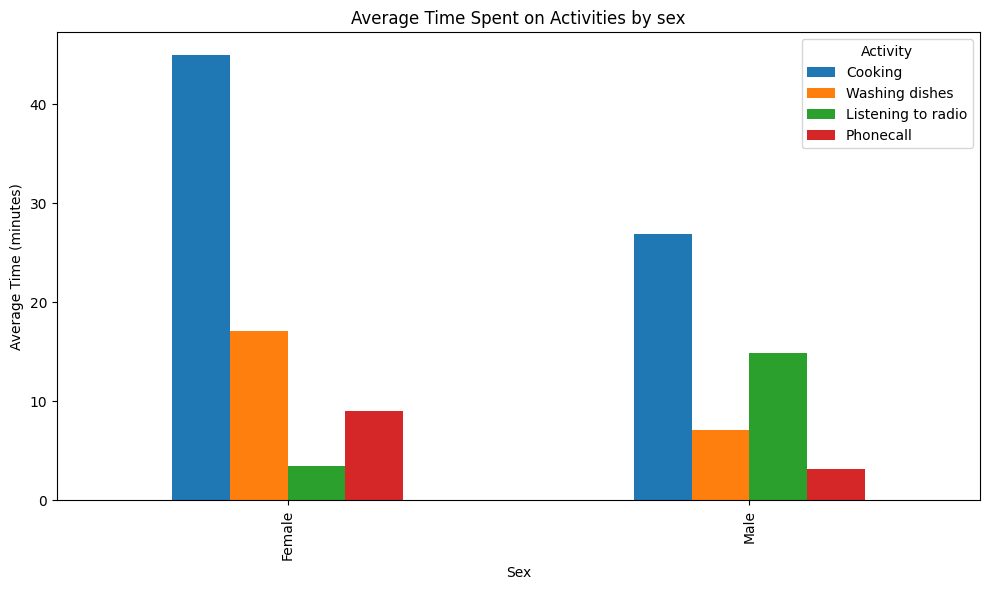

In [ ]:
# Calculate the average time spent on differences in activities based on sex
activity_means = data.groupby('Sex')[numerical_columns].mean()

# Display the average time for activities by sex
print("Average Time Spent on Activities by sex:\n", activity_means)

# Visualize the comparison using a bar plot
activity_means.plot(kind='bar', figsize=(10, 6))
plt.title('Average Time Spent on Activities by sex')
plt.ylabel('Average Time (minutes)')
plt.xlabel('Sex')
plt.legend(title='Activity', loc='upper right')
plt.tight_layout()
plt.show()

<ipython-input-29-464a028e00ca>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity_means = data.groupby('Age group')[numerical_columns].mean()


Average Time Spent on Activities by age group:
                    Cooking  Washing dishes  Listening to radio  Phonecall
Age group                                                                
20-24 years old  12.727273        2.727273            0.000000   0.909091
25-34 years old  27.291667        7.500000            0.000000   4.583333
35-44 years old  25.000000       10.192308            2.115385   4.807692
45-54 years old  31.000000       11.750000            9.875000   5.625000
55-64 years old  36.125000        9.750000            8.125000   5.875000
65-74 years old  55.531915       16.595745           15.957447   7.659574
75+ years old    77.600000       36.800000           25.600000  17.600000


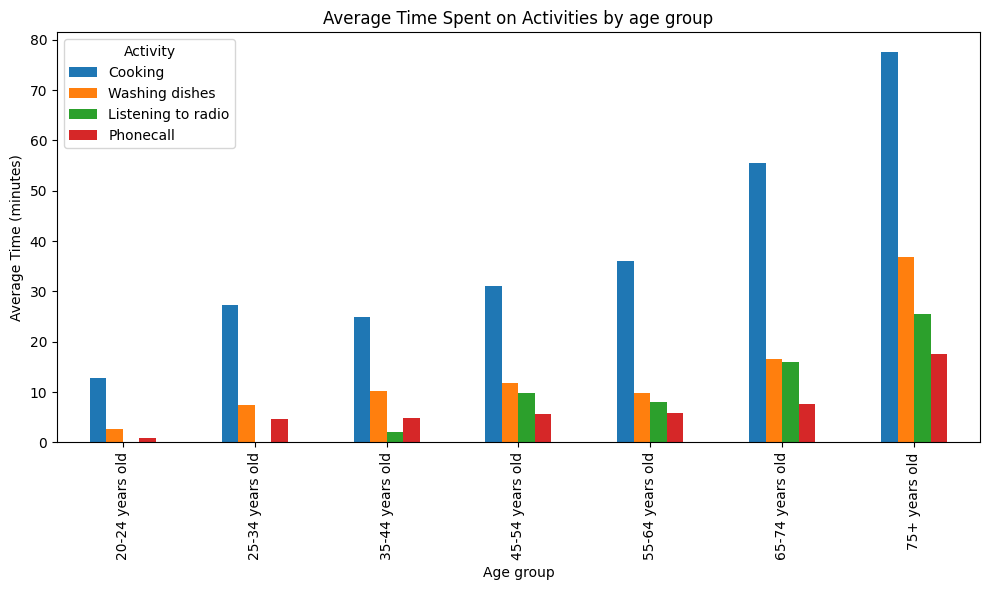

In [ ]:
# Calculate the average time spent on differences in activities based on age group
activity_means = data.groupby('Age group')[numerical_columns].mean()

# Display the average time for activities by age group
print("Average Time Spent on Activities by age group:\n", activity_means)

# Visualize the comparison using a bar plot
activity_means.plot(kind='bar', figsize=(10, 6))
plt.title('Average Time Spent on Activities by age group')
plt.ylabel('Average Time (minutes)')
plt.xlabel('Age group')
plt.legend(title='Activity', loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-30-ba1203361333>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity_means = data.groupby('Living environment')[numerical_columns].mean()


Average Time Spent on Activities by living Environment:
                       Cooking  Washing dishes  Listening to radio  Phonecall
Living environment                                                          
City                35.047170       11.273585           10.990566   7.075472
Municipality        38.909091       12.545455            0.909091   4.909091
Rural               40.789474       16.578947            7.368421   5.657895


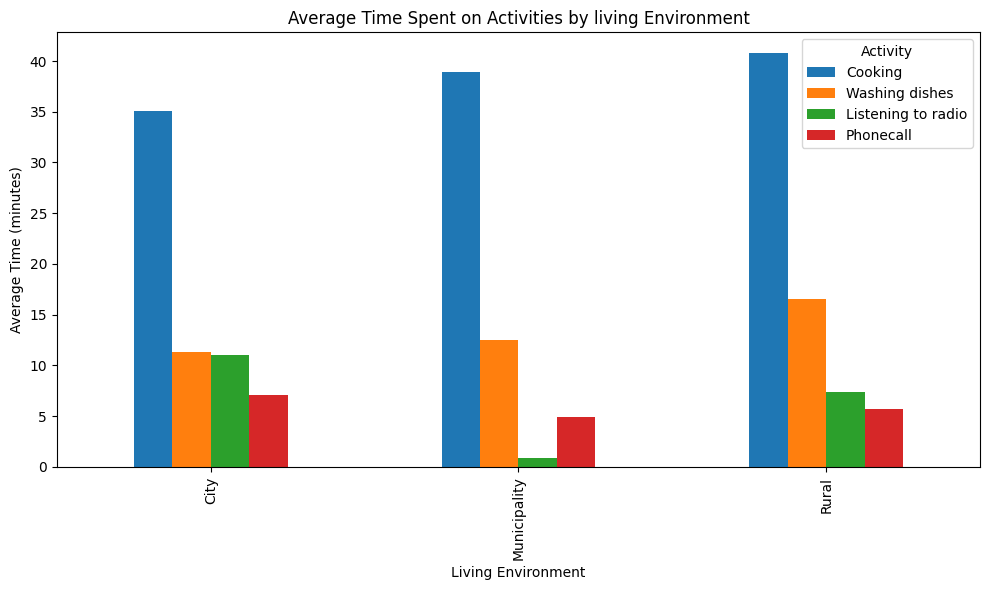

In [ ]:
# Calculate the average time spent on differences in activities based on living environments
activity_means = data.groupby('Living environment')[numerical_columns].mean()

# Display the average time for activities by living environment
print("Average Time Spent on Activities by living Environment:\n", activity_means)

# Visualize the comparison using a bar plot
activity_means.plot(kind='bar', figsize=(10, 6))
plt.title('Average Time Spent on Activities by living Environment')
plt.ylabel('Average Time (minutes)')
plt.xlabel('Living Environment')
plt.legend(title='Activity', loc='upper right')
plt.tight_layout()
plt.show()

Overall the most time is spent on cooking and washing dishes. Older people in the population seem to have more time for activities on average based on these graphs. On average, people living in rural areas spent more time on these activities than others. People living in cities spent the second most time on them and people in municipalities the least. Women spent almost 50% more time cooking and washing dishes on average than men.

We'll like to know more about the individuals in the data, so we analysed and visualized frequency of people visiting museums and libraries compared to age group, sex and living environment to have a better overiview of the individuals' behavior.

In [ ]:
# Compare sex to visiting a museum in the past year
counts = data.groupby(['Sex','Museum']).size().unstack()
data.groupby(['Sex','Museum']).size().unstack()

<ipython-input-31-ca51556be1fb>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['Sex','Museum']).size().unstack()
<ipython-input-31-ca51556be1fb>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['Sex','Museum']).size().unstack()


Museum,No,Yes
Sex,,
Female,106,84
Male,83,70


<Axes: title={'center': 'How many female and male have visited the museum in the past year'}, xlabel='Sex', ylabel='Relative frequency'>

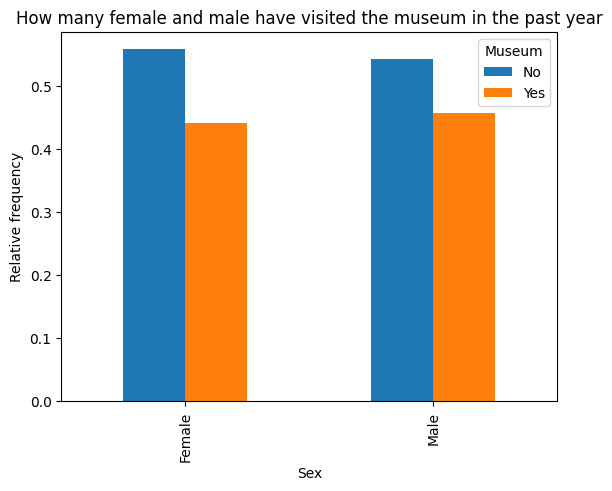

In [ ]:
# Since there are different size for both group, relative frequencies should be calculated
# Totals by value of 'sex' (i.e. sums over columns)
totals = counts.sum(axis=1)
# Relative frequencies per value of 'sex'
# (i.e. divide each element by the total that corresponds to its row name)
relative_counts = counts.div(totals, axis=0)
relative_counts.plot.bar(title='How many female and male have visited the museum in the past year', ylabel='Relative frequency')

In [ ]:
# Compare sex to visiting a library in the past year
counts = data.groupby(['Sex','Library']).size().unstack()
data.groupby(['Sex','Library']).size().unstack()

<ipython-input-33-25dabdfed02c>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['Sex','Library']).size().unstack()
<ipython-input-33-25dabdfed02c>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['Sex','Library']).size().unstack()


Library,No,Yes
Sex,,
Female,52,138
Male,60,93


<Axes: title={'center': 'How many female and male have visited the library in the past year'}, xlabel='Sex', ylabel='Relative frequency'>

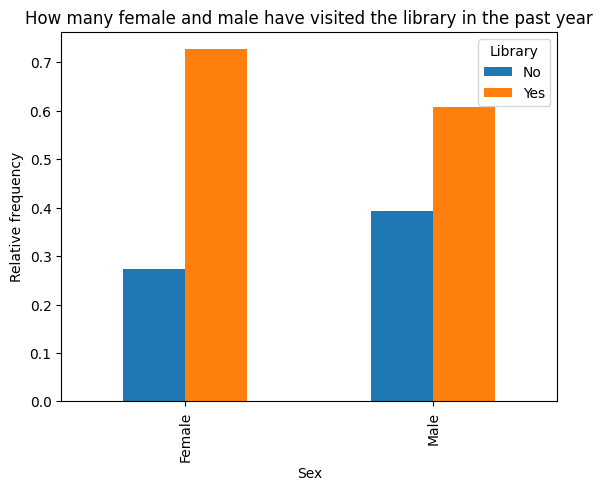

In [ ]:
totals = counts.sum(axis=1)
relative_counts = counts.div(totals, axis=0)
relative_counts.plot.bar(title='How many female and male have visited the library in the past year', ylabel='Relative frequency')

In [ ]:
# Compare age groups to visiting a museum in the past year
counts = data.groupby(['Age group','Museum']).size().unstack()
data.groupby(['Age group','Museum']).size().unstack()

<ipython-input-35-bcf623d84b13>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['Age group','Museum']).size().unstack()
<ipython-input-35-bcf623d84b13>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['Age group','Museum']).size().unstack()


Museum,No,Yes
Age group,,
20-24 years old,7,4
25-34 years old,30,18
35-44 years old,23,29
45-54 years old,39,41
55-64 years old,42,38
65-74 years old,30,17
75+ years old,18,7


<Axes: title={'center': 'How many have visited the museum in the past year within an age group'}, xlabel='Age group', ylabel='Relative frequency'>

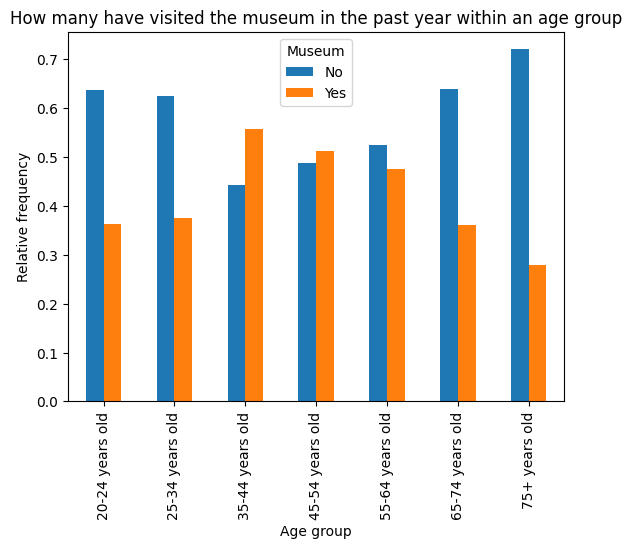

In [ ]:
totals = counts.sum(axis=1)
relative_counts = counts.div(totals, axis=0)
relative_counts.plot.bar(title='How many have visited the museum in the past year within an age group', ylabel='Relative frequency')

In [ ]:
# Compare age groups to visiting a library in the past year
counts = data.groupby(['Age group','Library']).size().unstack()
data.groupby(['Age group','Library']).size().unstack()

<ipython-input-37-0fc4cbdcb4e3>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['Age group','Library']).size().unstack()
<ipython-input-37-0fc4cbdcb4e3>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['Age group','Library']).size().unstack()


Library,No,Yes
Age group,,
20-24 years old,0,11
25-34 years old,3,45
35-44 years old,11,41
45-54 years old,27,53
55-64 years old,33,47
65-74 years old,23,24
75+ years old,15,10


<Axes: title={'center': 'How many have visited the library in the past year within an age group'}, xlabel='Age group', ylabel='Relative frequency'>

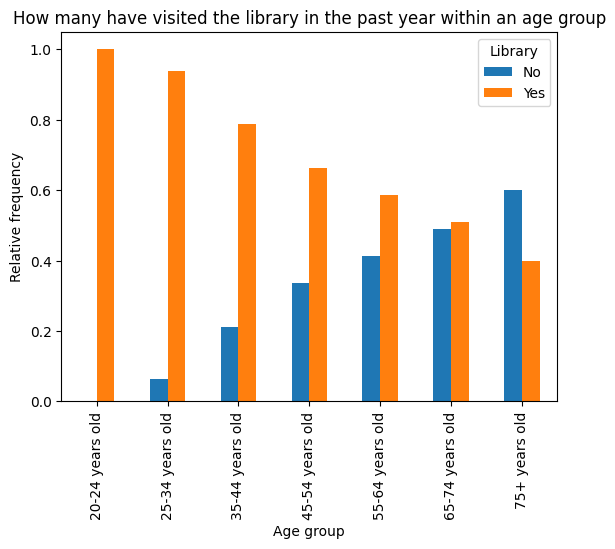

In [ ]:
totals = counts.sum(axis=1)
relative_counts = counts.div(totals, axis=0)
relative_counts.plot.bar(title='How many have visited the library in the past year within an age group', ylabel='Relative frequency')

In [ ]:
# Compare living environment to visiting a museum in the past year
counts = data.groupby(['Living environment','Museum']).size().unstack()
data.groupby(['Living environment','Museum']).size().unstack()

<ipython-input-39-c552f616ea2e>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['Living environment','Museum']).size().unstack()
<ipython-input-39-c552f616ea2e>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['Living environment','Museum']).size().unstack()


Museum,No,Yes
Living environment,,
City,114,98
Municipality,29,26
Rural,46,30


<Axes: title={'center': 'How many have visited the museum in the past year in each living environment'}, xlabel='Living environment', ylabel='Relative frequency'>

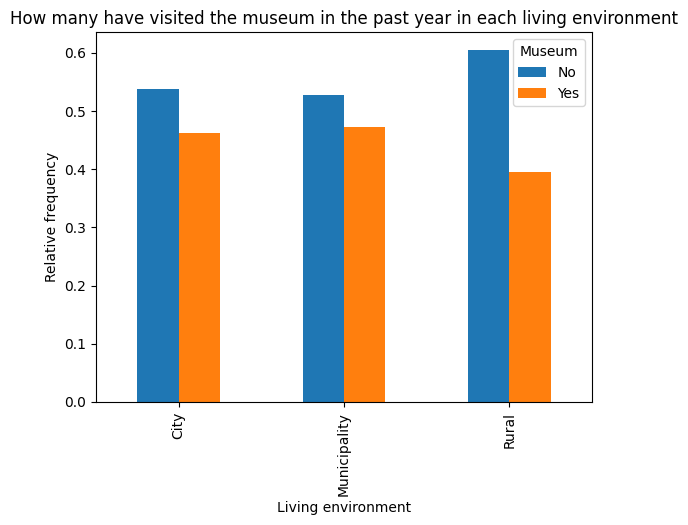

In [ ]:
totals = counts.sum(axis=1)
relative_counts = counts.div(totals, axis=0)
relative_counts.plot.bar(title='How many have visited the museum in the past year in each living environment', ylabel='Relative frequency')

In [ ]:
# Compare living environment to visiting a library in the past year
counts = data.groupby(['Living environment','Library']).size().unstack()
data.groupby(['Living environment','Library']).size().unstack()

<ipython-input-41-3c4011b7d4fe>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['Living environment','Library']).size().unstack()
<ipython-input-41-3c4011b7d4fe>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['Living environment','Library']).size().unstack()


Library,No,Yes
Living environment,,
City,70,142
Municipality,16,39
Rural,26,50


<Axes: title={'center': 'How many have visited the library in the past year in each living environment'}, xlabel='Living environment', ylabel='Relative frequency'>

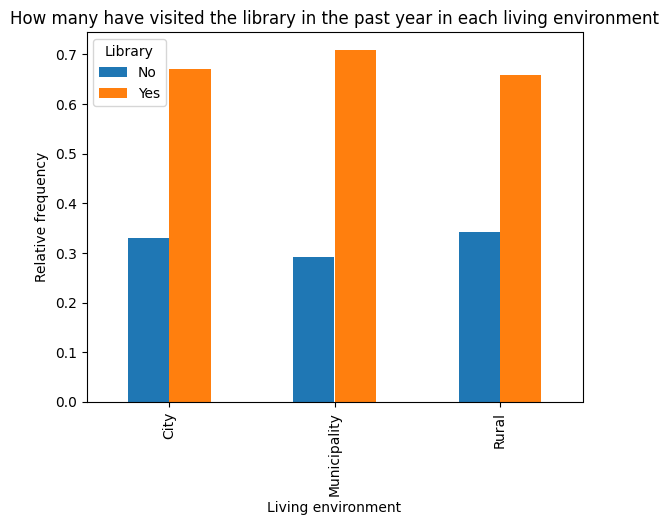

In [ ]:
totals = counts.sum(axis=1)
relative_counts = counts.div(totals, axis=0)
relative_counts.plot.bar(title='How many have visited the library in the past year in each living environment', ylabel='Relative frequency')

Based on these graphs, while there was not much difference between males and females in visiting libraries or museums, libraries were visited significantly more than museums. Younger and older people in this study's population seem to visit museums less than middle-aged people, of which almost half have visited in the past year. Library visits however seem steadily to lessen as the person gets older.

##2. Estimating how much time is spent on each activity on average

We can assume that the sample, which our estimation is based on, is a representative of the population.\
We will calculate and visualise average time spent on activities by household.

In [ ]:
# estimate how much household spends time on average daily by activity
mean_of_activies_by_household = data.groupby('household ID')[numerical_columns].sum().mean()
data.groupby('household ID')[numerical_columns].sum().mean()

,0
Cooking,36.938776
Washing dishes,12.653061
Listening to radio,8.571429
Phonecall,6.413994


<Axes: title={'center': 'Average of time spend on activities by households'}, ylabel='Minutes'>

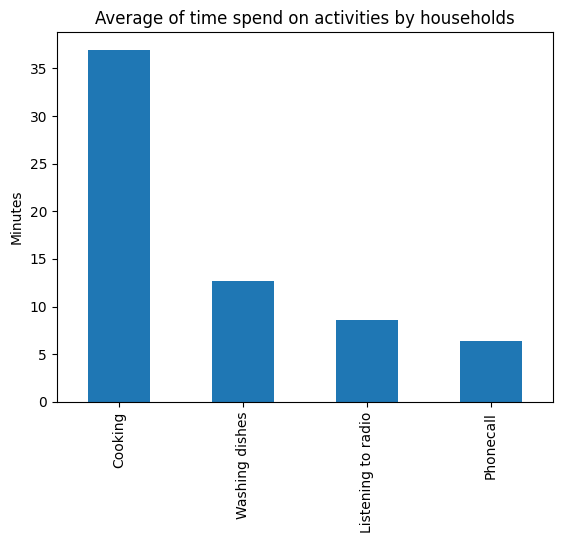

In [ ]:
mean_of_activies_by_household.plot.bar(title='Average of time spend on activities by households',
                                       ylabel='Minutes')

Based on the estimation it seems that the households in the population tend to use the most time on cooking and the least on talking on the phone.

##3. Finding differences in time spent on the activities by day of week

Firstly we calculate and visualise the average time spent on activities based on the day of week.

<ipython-input-45-32d12b607e76>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity_means = data.groupby('Day of week')[numerical_columns].mean()


Average Time Spent on Activities by day of week:
                Cooking  Washing dishes  Listening to radio  Phonecall
Day of week                                                          
weekend      33.595506        9.831461            9.213483   5.842697
working day  40.545455       15.696970            7.878788   7.030303


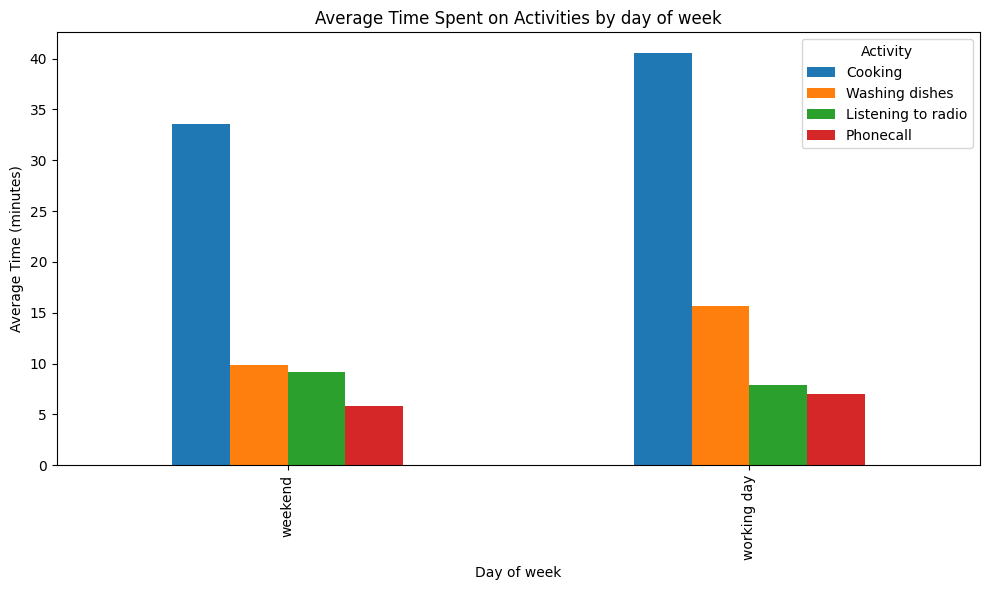

In [ ]:
##This is a duplicate from section 1. where we used it to characterise individuals

# Calculate the average time spent on differences in activities based on day of week
activity_means = data.groupby('Day of week')[numerical_columns].mean()

# Display the average time for activities by day of week
print("Average Time Spent on Activities by day of week:\n", activity_means)

# Visualize the comparison using a bar plot
activity_means.plot(kind='bar', figsize=(10, 6))
plt.title('Average Time Spent on Activities by day of week')
plt.ylabel('Average Time (minutes)')
plt.xlabel('Day of week')
plt.legend(title='Activity', loc='upper right')
plt.tight_layout()
plt.show()

 By looking at the graph above, we can have an overall view about time spent activities between working days and weekends:
- Cooking: time spent on cooking mostly on working days (40.54 minutes) which is higher than weekends (33.59 minutes). It means that people prefer less cooking on weekends so that they can rest or spend time on other activities
- Washing dishes: Time spent on washing dishes (15.69 minutes) is higher than weekends (9.8 minutes), which indicates people prefer eating at home on working days, leading to more time washing dishes, while on weekends they may like to eat outside and less cooking.
- Listening to Radio: There is no big difference in radio listening time between workdays (7.87 minutes) and weekends (9.21 minutes). This shows that the habits of listening to radio do not change much between workdays and weekends, they may listen in their free time or when doing other things.
- Phone call: The average time spent making phone calls is slightly higher on workdays (7.03 minutes) than on weekends (5.84 minutes). The reason can be work-related calls is more than on weekends.

#### Summary
Overall, time spent on cooking and dishwashing activities seemed to decrease on weekends, while time spent on activities such as listening to the radio, making phone calls, visiting museums, and visiting the library did not change too much between workdays and weekends. Heavy housework activities such as cooking and washing dishes tend to decrease on weekends, possibly reflecting the need to rest and reduce stress on these days.

Next we will apply statistical testing to find evidence if day of the week is associated to time spent on activities.

First step is to test if the data is normal. We'll test the variables' normality with Shapiro-Wilk test. The null hypothesis is that is that the dataset is normally distributed [1].

In [ ]:
# Test for normality
normality = lambda a: s.shapiro(a).pvalue
print(data.groupby('Day of week')['Cooking'].apply(normality))
print(data.groupby('Day of week')['Washing dishes'].apply(normality))
print(data.groupby('Day of week')['Listening to radio'].apply(normality))
print(data.groupby('Day of week')['Phonecall'].apply(normality))

Day of week
weekend        3.683398e-17
working day    1.805845e-11
Name: Cooking, dtype: float64
Day of week
weekend        5.364922e-19
working day    9.148754e-15
Name: Washing dishes, dtype: float64
Day of week
weekend        3.926256e-25
working day    1.654761e-26
Name: Listening to radio, dtype: float64
Day of week
weekend        1.249983e-23
working day    9.539748e-22
Name: Phonecall, dtype: float64


<ipython-input-46-36d2319ad690>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('Day of week')['Cooking'].apply(normality))
<ipython-input-46-36d2319ad690>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('Day of week')['Washing dishes'].apply(normality))
<ipython-input-46-36d2319ad690>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('Day of week')['Listening to 

We can assume normality based on the high p-values obtained in the test for normality for all variables. Here we'll test two unpaired variables so we will apply unpaired T-test. The test's null hypothesis states that there is no significant difference between the means of the two groups [2].

In [ ]:
# assume normality due to high p-values, test with unpaired T-test
p_t_cooking = s.ttest_ind(data[data['Day of week'] == 'working day']['Cooking'], data[data['Day of week'] == 'weekend']['Cooking']).pvalue
p_t_dishes = s.ttest_ind(data[data['Day of week'] == 'working day']['Washing dishes'], data[data['Day of week'] == 'weekend']['Washing dishes']).pvalue
p_t_radio = s.ttest_ind(data[data['Day of week'] == 'working day']['Listening to radio'], data[data['Day of week'] == 'weekend']['Listening to radio']).pvalue
p_t_phonecall = s.ttest_ind(data[data['Day of week'] == 'working day']['Phonecall'], data[data['Day of week'] == 'weekend']['Phonecall']).pvalue

print(p_t_cooking)
print(p_t_dishes)
print(p_t_radio)
print(p_t_phonecall)

0.11924730669038067
0.004017561018094432
0.7420208251463922
0.5038410577452723


In [ ]:
print(data[data['Day of week'] == 'working day']['Washing dishes'].mean())
print(data[data['Day of week'] == 'weekend']['Washing dishes'].mean())

15.696969696969697
9.831460674157304


Based on the p-values obtained by unpaired T-test, we can see that there's no statistical evidence that time spent on cooking, listening to radio or phonecall have difference between working days and weekend. However, there's evidence that washing dishes tend to be done more on one group than the other.

Since we are running multiple tests in the same dataset simultaneously, we should correct the tests' p-values. This is done to identify if the false positivies in the test results [3]. We will use Bonferroni correction to correct the p-values.

In [ ]:
# Use Bonferroni correction
p_values = [p_t_cooking, p_t_dishes, p_t_radio, p_t_phonecall]
ssm.multipletests(p_values, method='bonferroni')[1]

array([0.47698923, 0.01607024, 1.        , 1.        ])

After correcting the values we can see that there's no difference in the significance, so the evidence found before seems to be valid.

##4. Finding differences in time spent on the activities by living environment

Firstly we calculate and visualise the average time spent on activities based on living environments.

<ipython-input-50-4e2541126dcc>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity_means = data.groupby('Living environment')[numerical_columns].mean()


Average Time Spent on Activities by living Environment:
                       Cooking  Washing dishes  Listening to radio  Phonecall
Living environment                                                          
City                35.047170       11.273585           10.990566   7.075472
Municipality        38.909091       12.545455            0.909091   4.909091
Rural               40.789474       16.578947            7.368421   5.657895


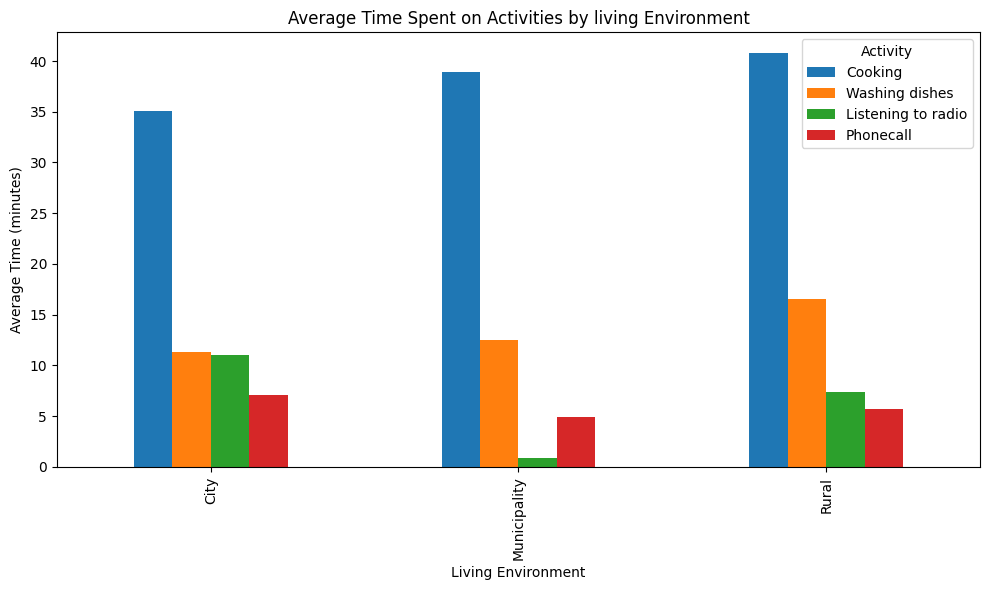

In [ ]:
##This is a duplicate from section 1. where we used it to characterise individuals

# Calculate the average time spent on differences in activities based on living environments
activity_means = data.groupby('Living environment')[numerical_columns].mean()

# Display the average time for activities by living environment
print("Average Time Spent on Activities by living Environment:\n", activity_means)

# Visualize the comparison using a bar plot
activity_means.plot(kind='bar', figsize=(10, 6))
plt.title('Average Time Spent on Activities by living Environment')
plt.ylabel('Average Time (minutes)')
plt.xlabel('Living Environment')
plt.legend(title='Activity', loc='upper right')
plt.tight_layout()
plt.show()

In the average time spent on activities based on living environment, cooking and washing dishes account for the most time across all areas. The rural area spends the most time on both cooking and washing dishes compared to city and municipality. Additionally, the residents in city and rural tends to spend more time on listening to radio than those in municipality. Hoever, the time spent on visiting museums and libraries is quite similar across all three areas.
#### Summary
- All regions tends to spend their times on cooking and washing dishes, with the city spent the least time on these activities.
- The residents in the cityspent more time on listening to radio which is oppsite of those live in municipality area.
- Time spent on visiting museum and library is quite similar across all living environment.

Next we'll try to find statistical evidence of living environment associating with time spent on each activity by applying statistical test. Again the first step is to calculate normality, and we'll use Shapiro-Wilk test for that.

In [ ]:
# Test for normality
normality = lambda a: s.shapiro(a).pvalue
print(data.groupby('Living environment')['Cooking'].apply(normality))
print(data.groupby('Living environment')['Washing dishes'].apply(normality))
print(data.groupby('Living environment')['Listening to radio'].apply(normality))
print(data.groupby('Living environment')['Phonecall'].apply(normality))

Living environment
City            1.295625e-17
Municipality    1.905467e-07
Rural           4.519422e-07
Name: Cooking, dtype: float64
Living environment
City            2.789426e-19
Municipality    2.988767e-07
Rural           1.448247e-10
Name: Washing dishes, dtype: float64
Living environment
City            2.781124e-28
Municipality    2.257244e-15
Rural           3.323618e-17
Name: Listening to radio, dtype: float64
Living environment
City            7.110511e-25
Municipality    2.876741e-13
Rural           3.085402e-15
Name: Phonecall, dtype: float64


<ipython-input-51-72f837b37030>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('Living environment')['Cooking'].apply(normality))
<ipython-input-51-72f837b37030>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('Living environment')['Washing dishes'].apply(normality))
<ipython-input-51-72f837b37030>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('Living environ

Due to the high p-values, we can assume that the data is normal. Since the data is normally distributed and we'll have to apply test for multiple unpaired values, we will use ANOVA. The null hypothesis in ANOVA is that the means of the groups are not significantly different [5].

In [ ]:
p_a_cooking = s.f_oneway(data[data['Living environment'] == 'City']['Cooking'],
                 data[data['Living environment'] == 'Municipality']['Cooking'],
                 data[data['Living environment'] == 'Rural']['Cooking'])
p_a_dishes = s.f_oneway(data[data['Living environment'] == 'City']['Washing dishes'],
                 data[data['Living environment'] == 'Municipality']['Washing dishes'],
                 data[data['Living environment'] == 'Rural']['Washing dishes'])
p_a_radio = s.f_oneway(data[data['Living environment'] == 'City']['Listening to radio'],
                 data[data['Living environment'] == 'Municipality']['Listening to radio'],
                 data[data['Living environment'] == 'Rural']['Listening to radio'])
p_a_phonecall = s.f_oneway(data[data['Living environment'] == 'City']['Phonecall'],
                 data[data['Living environment'] == 'Municipality']['Phonecall'],
                 data[data['Living environment'] == 'Rural']['Phonecall'])

print(p_a_cooking)
print(p_a_dishes)
print(p_a_radio)
print(p_a_phonecall)

F_onewayResult(statistic=0.6150287800038885, pvalue=0.5412256844691998)
F_onewayResult(statistic=2.211383605174631, pvalue=0.11112227149093898)
F_onewayResult(statistic=1.63970308504325, pvalue=0.19556825223405488)
F_onewayResult(statistic=0.4827571963186801, pvalue=0.6175019597524363)


Based on the p-values obtained, there appears to be no statistical evidence that time spent on the activities has difference between the living environments.

Since there's multiple simultaneous tests, we should apply multiple correction again.

In [ ]:
# Use Bonferroni correction
p_values = [p_a_cooking[1], p_a_dishes[1], p_a_radio[1], p_a_phonecall[1]]
ssm.multipletests(p_values, method='bonferroni')[1]

array([1.        , 0.44448909, 0.78227301, 1.        ])

After correcting the p-values, we can see that there's no significant difference when comparing to the p-values obtained from the test.

##5. Exploring which of the activities are associated with each other

Next we use another way of estimating and visualising correlations between activities using matrixes. First by using pearson correlation coefficient and then by using spearman's rank correlation coefficient.

Activity Correlation Matrix:
                      Cooking  Washing dishes  Listening to radio  Phonecall
Cooking             1.000000        0.495309            0.098799   0.072268
Washing dishes      0.495309        1.000000            0.012370   0.172762
Listening to radio  0.098799        0.012370            1.000000  -0.019309
Phonecall           0.072268        0.172762           -0.019309   1.000000


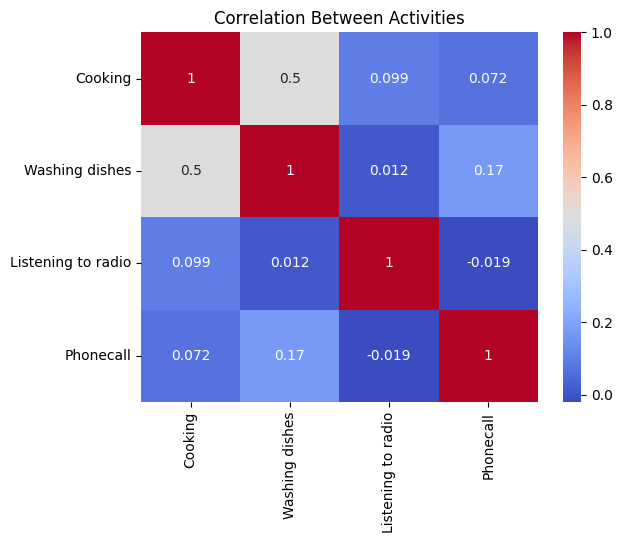

In [ ]:
# Identify pearson correlation between activities
activity_corr = data[numerical_columns].corr()
print("Activity Correlation Matrix:\n", activity_corr)

# Visualize the correlation matrix
sns.heatmap(activity_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Between Activities')
plt.show()

The relationship between activities with Pearson correlation:
- Cooking and Washing dishes: The correlation value is 0.5, indicating a moderate positive relationship. This means that as cooking time increases, dishwashing time also tends to increase.
- Listening to radio: Listening to the radio has a very low correlation with most other activities. This may reflect that radio listening time does not depend much on other activities
- Phone call: The correlation between phone calls and cooking is 0.1, which is very low, suggesting that there is no relationship between phone calls and cooking time. The negative correlation between phone calls and museum visits (-0.01), suggests that people who spend more time on calls tend to visit museums less, but the magnitude is very weak.

Activity Correlation Matrix:
                      Cooking  Washing dishes  Listening to radio  Phonecall
Cooking             1.000000        0.536558            0.114889   0.052429
Washing dishes      0.536558        1.000000            0.054925   0.168064
Listening to radio  0.114889        0.054925            1.000000   0.050967
Phonecall           0.052429        0.168064            0.050967   1.000000


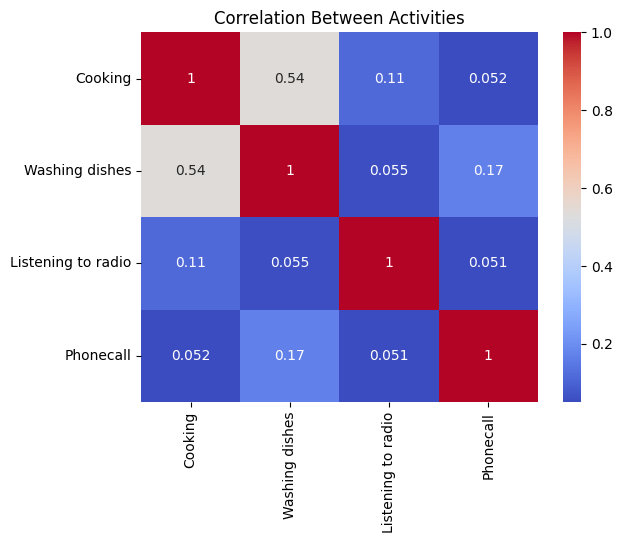

In [ ]:
# Identify spearman correlation between activities
activity_corr = data[numerical_columns].corr(method='spearman')
print("Activity Correlation Matrix:\n", activity_corr)

# Visualize the correlation matrix
sns.heatmap(activity_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Between Activities')
plt.show()

The relationship between activities with Spearman's correlation:
- Cooking and washing dishes still have the highest correlation (0.54), but the value is larger than Pearson's, suggesting that the relationship between these two activities is monotonic and may not be completely linear.
- Cooking and Listening to radio are slightly more highly correlated than Pearson (0.11), suggesting that there may be a weaker monotonic relationship between cooking and listening to radio.
- Listening to radio and Phonecall have a slight positive correlation (0.051), different from the very small negative correlation in Pearson. This may suggest that there is a slight positive relationship between these two activities, although not clearly linear.



#### Summary
- Pearson provides information about the linear relationship between activities, especially the relationship between Cooking and Washing dishes. The other relationships are very weak or almost non-linear.
- Spearman helps identify milder, though less linear, monotonic relationships as seen between Listening to radio and Phonecall. This suggests that there is a weak but positive association between some activities, even if the relationship is not perfectly linear.

Now we would like to find out if there's any evidence of correlation between the different activities. The first step is to asses normality of each activity.

In [ ]:
print(data[numerical_columns].apply(normality))

Cooking               5.775050e-21
Washing dishes        8.916013e-24
Listening to radio    4.270368e-35
Phonecall             5.949314e-31
dtype: float64


The high p-values suggests that the data is normal. Based on the normality, for testing the correlation between the activities we will use Pearson correlation coefficient. The null hypothesis is that there is no correlation [6].


In [ ]:
# due to high p-values, assume normality, so test with Pearson correlation coefficent
print(s.pearsonr(data['Cooking'], data['Washing dishes']))
print(s.pearsonr(data['Cooking'], data['Listening to radio']))
print(s.pearsonr(data['Cooking'], data['Phonecall']))
print(s.pearsonr(data['Washing dishes'], data['Listening to radio']))
print(s.pearsonr(data['Washing dishes'], data['Phonecall']))
print(s.pearsonr(data['Listening to radio'], data['Phonecall']))

PearsonRResult(statistic=0.4953088153322389, pvalue=1.2418214261167943e-22)
PearsonRResult(statistic=0.09879919828799655, pvalue=0.06761246414446713)
PearsonRResult(statistic=0.0722678816000973, pvalue=0.18178452971548276)
PearsonRResult(statistic=0.012370157864115232, pvalue=0.8194356040191497)
PearsonRResult(statistic=0.17276212233349433, pvalue=0.0013176620161033249)
PearsonRResult(statistic=-0.019309316664651285, pvalue=0.7215849621506232)


Almost all of the tests yielded a high p-value, which means that there's no evidence of correlation between those variables. However, the test for washing dishes and phonecall resulted in a low p-value, which indicates that there is statistical evidence to claim there is correlation between the variables.

##Conclusions

###1. Characterise individuals that are present in the data

Clustering (K-prototype) was used to see the distributions between different groups with similar behaviours throughout different clusters. Clusters 0 and 1 have the same gender and similar times spent on listening to radio and cooking. Clusters 1 and 2 have similar amounts of people visiting libraries. The cluster 0 however has only 6 people, which should be taken into account when interpreting the values the group gets. A single outlier in a group that small can affect the results greatly.

###2. Estimate how much time on average households spend daily on each activity

We estimated the average time spent on activies daily based on population. The estimation suggested that cooking took the most time on average and phone calls took the least time.

###3. With respect to which activities do working days and weekends differ?

Based on the descriptive analysis, we could conclude that cooking, dishwashing, and phone calls seem to require more time during the week than on the weekends, whereas on the weekends people spend more time listening to the radio and less time on other activities.

Based on the statistical tests, we found evidence of that washing dishes is done more on working days or weekends. Based on the graph "Average Time Spent on Activities by day of week" we could conclude, that washing dishes occurs more on the working days than on weekends.

###4. With respect to which activities do living environments differ?

From the descriptive analysis we could see, that cooking and washing dishes have the highest time spent on all living envonments. The highest time spent is on phone calls and it is quite similar on all environments. On the other hand, people in the municipalities did not spend much time listening to radio, compared to other living environments.

After applying statistical tests to the appropriate variables, there appears to be no statistical evidence of significant difference on time spent on activities between the living environments.

###5. Which activities are associated with each other?

In the descriptive analysis, it seemed that cooking and dishwashing have a moderate positive relationship, which is reasonable because cooking may relate to the need to wash dishes. Listening to the radio and other activities did not have a significant relationship, possibly because listening to the radio did not depend on other activities.

When statistical tests were applied to the activity variables, the test for washing dishes and phonecalls resulted in a low p-value, which indicates that there is statistical evidence to claim there is correlation between the variables. In the descriptive analysis there seemed to be low positive correlation between the activities.

##Sources
1. https://guides.library.lincoln.ac.uk/mash/statstest/shapiro-wilk
2. https://www.statstutor.ac.uk/resources/uploaded/unpaired-t-test.pdf
3. https://docs.ufpr.br/~giolo/LivroADC/Material/S3_Bonferroni%20Correction.pdf
4. https://medium.com/@reddyyashu20/k-means-kmodes-and-k-prototype-76537d84a669
5. https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/anova/
6. https://datatab.net/tutorial/pearson-correlation
7. https://antonsruberts.github.io/kproto-audience/